### Playing around with hard disk failure data

(source: Kaggle https://www.kaggle.com/ezeydan/hard-drive-failure-data)

In [1]:
import os

# Install reliability from my repo first
#if os.path.exists("/home/markus/src/reliability"):
#    !pip3 install /home/markus/src/reliability
#else:
#    !pip3 install -U git+https://github.com/sedgewickmm18/reliability


In [2]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
        
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import statsmodels.api as sm
import networkx as nx

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import reliability as rl

from reliability.Distributions import (Weibull_Distribution,Competing_Risks_Model)
from reliability.Fitters import (Fit_Weibull_2P, Fit_Weibull_3P, Fit_Everything, Fit_Weibull_CR, 
                                 Fit_GeneralizedPareto_3P, Fit_Normal_2P, Fit_Gumbel_2P,
        Fit_Weibull_Mixture, Fit_Lognormal_2P, Fit_Lognormal_3P, Fit_Gamma_2P, Fit_Gamma_3P)
from reliability.Probability_plotting import (Normal_probability_plot, Weibull_probability_plot, 
        Exponential_probability_plot, QQ_plot_parametric, QQ_plot_semiparametric)
from reliability.Nonparametric import KaplanMeier

register_matplotlib_converters()

#EngineLogging.configure_console_logging(logging.INFO)


In [4]:
df_2 = pd.read_csv('./data/2015-alloutages-noSLA.csv')
outage_sev = df_2['SevMinutes'].values
outage_sev.sort()
#outage_Sev = outage_sev[0:-1]
df_2[['SevMinutes','Date']].set_index('Date').to_csv('test.csv')

In [84]:
outage_Sev = np.concatenate((outage_sev[:-1],-outage_sev[:-1]))
outage_Sev.sort()
#outage_Sev = outage_Sev/1000

<AxesSubplot:ylabel='Proportion'>

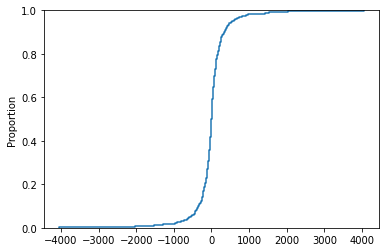

In [85]:
sns.ecdfplot(outage_Sev)

#### Kneepoints

By intuition the distribution's tail starts with the kneepoint of its (E)CDF.

See also 
https://towardsdatascience.com/detecting-knee-elbow-points-in-a-graph-d13fc517a63c

In [25]:
import kneed
from statsmodels.distributions.empirical_distribution import ECDF

outecdf = ECDF(outage_sev)(np.arange(0,20000,5))
kneedle = kneed.KneeLocator(range(len(outecdf[:])), outecdf[:], 
                            curve="concave", direction="increasing", interp_method="interp1d", S=0)
kneedle.knee, outecdf[kneedle.knee]

(27, 0.555)

Text(0.5, 1.0, 'Knee point ECDF at 55%')

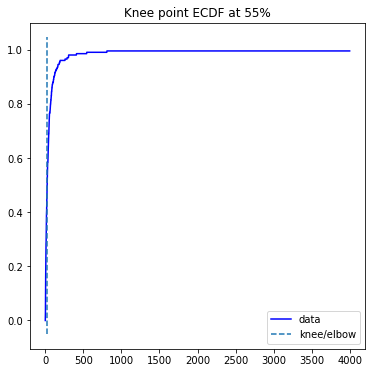

In [26]:
kneedle.plot_knee()
plt.title('Knee point ECDF at ' + str(int(outecdf[kneedle.knee]*100)) + '%')

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 199/0 (0% right censored) 

        Distribution   Alpha     Beta   Gamma Alpha 1   Beta 1 Alpha 2   Beta 2 Proportion 1 DS      Mu   Sigma     Lambda       Xi  Log-likelihood    AICc     BIC       AD optimizer
        Lognormal_2P                                                                            4.70573 1.32782                            -1275.23 2554.53 2561.05 0.484518       TNC
      Loglogistic_2P 113.367  1.31067                                                                                                      -1277.53 2559.12 2565.65 0.660935       TNC
        Lognormal_3P                        0                                                   4.70573 1.32782                            -1275.23 2556.59 2566.35 0.484518       TNC
      Loglogistic_3P 112.374  1.29276 0.61907                                                                                              -1277.36 2560.83 2570.59

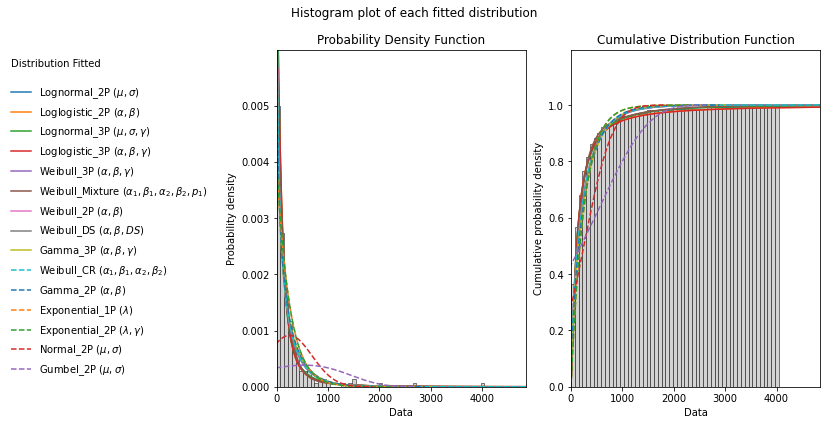

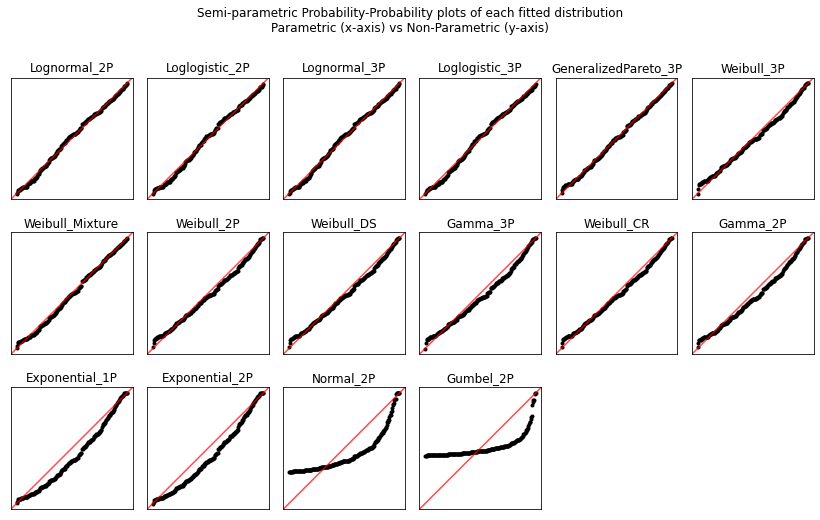

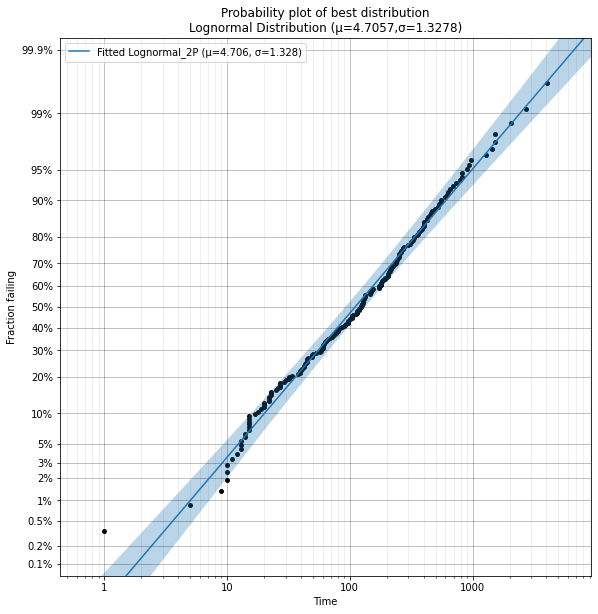

In [27]:
# so cut off the first 58% of the sorted data and fit a distribution to the rest 
fit_ee = Fit_Everything(failures=outage_sev[:-1], show_probability_plot=False)

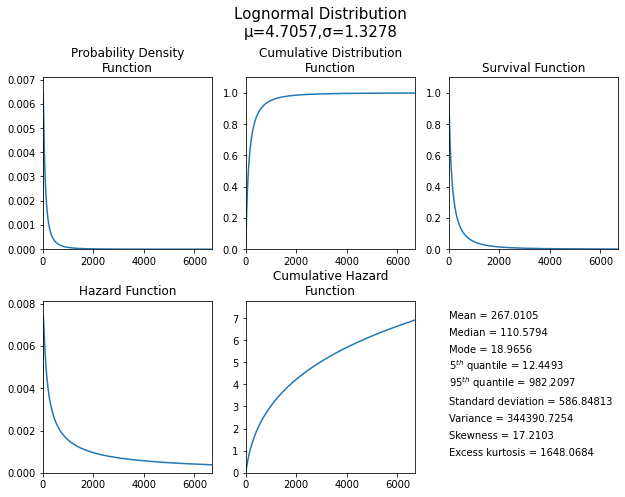

In [28]:
fit_ee.best_distribution.plot()

In [94]:
parms = sp.stats.tukeylambda.fit(outage_Sev[:], method="MM")
parms

(0.999999542299177, -2.4725771468987495e-26, 873.0217617457974)

In [96]:
parms = sp.stats.tukeylambda.fit(outage_Sev[:], method="MLE")
parms

(-0.6169080347241901, 0.003227888458115214, 63.817019030960886)

In [97]:
tl = sp.stats.tukeylambda(parms[0], loc=parms[1], scale=parms[2])

In [186]:
log_likelihoodt = np.sum(np.log(tl.pdf(outage_Sev)))
log_likelihoodt

-2832.212742103211

In [98]:
parms

(-0.6169080347241901, 0.003227888458115214, 63.817019030960886)

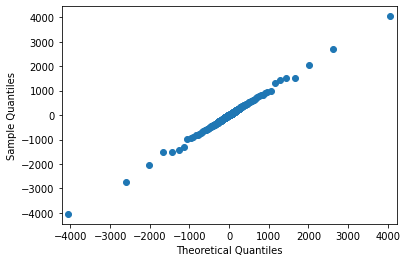

In [195]:
sm.qqplot(outage_Sev, tl)
plt.show()

In [174]:
r = tl.rvs()
x = np.linspace(tl.ppf(0.01),
                tl.ppf(0.99), 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


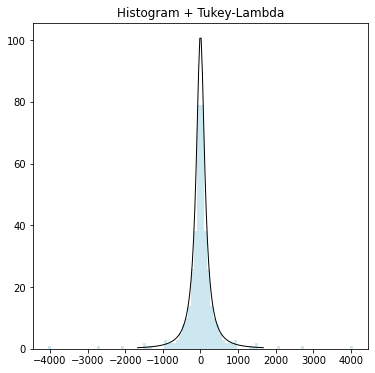

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.legend(loc='best', frameon=False)
ax.plot(x, tl.pdf(x)*40000, 'k-', lw=1, label='tukey pdf')
ax.hist(outage_Sev, alpha=0.6, color='lightblue',  bins=100, label='histogram')
ax.set_title('Histogram + Tukey-Lambda')

plt.show()

In [160]:
#sp.stats.ppcc_max(outage_Sev,brack=[0.1,5], dist='tukeylambda') #plot=plt,

-0.5344469447441331

In [181]:
parms_su = sp.stats.johnsonsu.fit(outage_Sev)
parms_su

(-2.52661872714022e-07,
 0.6712183776645049,
 -1.1177556800195684e-05,
 99.29768002452963)

In [167]:
josu = sp.stats.johnsonsu(parms_su[0], parms_su[1], loc=parms_su[2], scale=parms_su[3])

In [185]:
log_likelihoodj = np.sum(np.log(josu.pdf(outage_Sev)))
log_likelihoodj

-2830.8100633627637

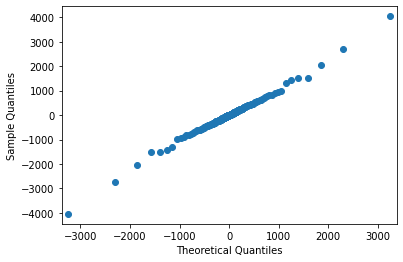

In [192]:
import statsmodels.api as sm
sm.qqplot(outage_Sev, josu)
plt.show()

In [197]:
rs = josu.rvs(size=3000)
xs = np.linspace(tl.ppf(0.01),
                tl.ppf(0.99), 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


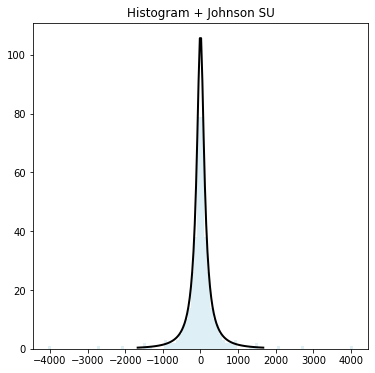

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.legend(loc='best', frameon=False)
ax.plot(xs, josu.pdf(xs)*40000, 'k-', lw=2, label='johnsonsu pdf')
ax.hist(outage_Sev, alpha=0.4, color='lightblue',  bins=100, label='histogram')
ax.set_title('Histogram + Johnson SU')

plt.show()

In [200]:
# Fit a tukey lambda to 'our' Johnson SU to understand the lambda parameter
parms_tl = sp.stats.tukeylambda.fit(rs, method="MLE")
parms_tl

(-0.6346946082127171, -6.030243206942426, 64.02090662640589)

In [206]:
parms_ln = sp.stats.lognorm.fit(outage_sev[:-1])

In [205]:
parms_ln

(1.3586401515172986, -0.5203668893260753, 114.87809273924682)

In [232]:
ln = sp.stats.lognorm(parms_ln[0], loc=parms_ln[1], scale=parms_ln[2])

In [235]:
lns = ln.rvs(size=1000)
lns_symm = np.concatenate([lns,-lns])

In [236]:
parms_tln = sp.stats.tukeylambda.fit(lns_symm, method="MLE")
parms_tln

(-0.757265499790832, 0.024959024321395844, 53.527978003295274)

In [92]:
from gldpy import GLD
gld = GLD('VSL')



Sample L-moments:  (251.80904522613065, 158.29709151819705, 0.5501035850160724, 0.3701843872290633)
Fitted L-moments:  (251.80904522613065, 158.29709151819705, 0.5486973285744055, 0.3701843872290634)

Parameters:  [  1.25390049 146.0275085    1.          -0.41718415]


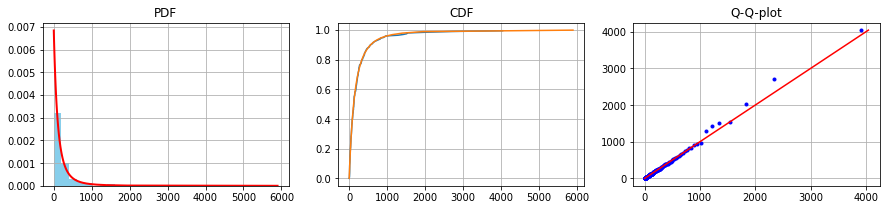

In [93]:
param_MM = gld.fit_LMM(outage_sev[:-1], 0, bins_hist=20, maxiter=1000, maxfun=1000, test_gof=False)


Sample L-moments:  (259.737947987216, 168.85816351824573, 0.5864927269627268, 0.398607146243362)
Fitted L-moments:  (259.73794798721605, 168.85816351824573, 0.574071941179698, 0.39860714624335997)

Parameters:  [ -0.50286193 140.83709911   1.          -0.45882009]


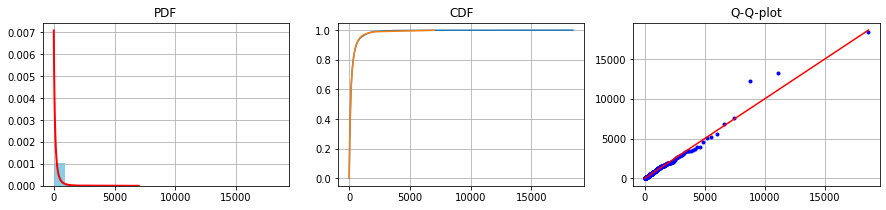

In [47]:
rv = fit_ee.best_distribution.random_samples(4000)
param_MM2 = gld.fit_LMM(rv, bins_hist=20, maxiter=1000, maxfun=1000, test_gof=False)

In [48]:
#fig, ax = plt.subplots(1, 1)
#sp.stats.ppcc_plot(outage_Sev[:], 0.01, 10, dist='lognorm', plot=ax)
#sp.stats.ppcc_plot(outage_Sev[:], 0.01, 200, plot=ax)

### ToDos

- Actually the majority of examples appear to be (almost) Weibull distributed. While we can apply the Anderson-Darling test, I have no clue what the resulting statistic means, i.e. about weibull critical values in general. I need to implement [Two- and Three-Parameter Weibull Goodness-of-Fit Tests](https://www.fpl.fs.fed.us/documnts/fplrp/fplrp493.pdf).


In [9]:
#fd = pd.read_csv('./data/machine_failure_data.csv')
fd = pd.read_csv('./data/hard_drive_failure_data.csv')


### Exploratory analysis

In [10]:
# check of right censored data

fd[fd['failure'] != 1]

,@timestamp,@version,capacity_bytes,date,failure,model,serial_number,lifetime


#### No right-censored data !

In [11]:
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

describe(fd[['lifetime']], ['skew', 'mad', 'kurt'])

,lifetime
count,2987
mean,308.559
std,210.715
min,0
25%,119
50%,290
75%,480
max,730
skew,0.245452
mad,183.523


In [12]:
#fd_pos = fd[fd['lifetime']>0]
#describe(fd_pos[['lifetime']], ['skew', 'mad', 'kurt'])

In [13]:
lifetimes_all = fd['lifetime'].values
lifetimes_all.sort()
#plt.scatter(range(len(lifetimes_all)), lifetimes_all)

<AxesSubplot:ylabel='Count'>

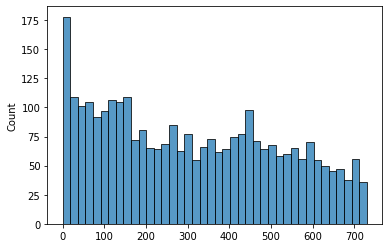

In [14]:
sns.histplot(data=lifetimes_all, bins=40)

In [15]:
lifetimes_all_pos = lifetimes_all[lifetimes_all > 0]
lifetimes_trans = lifetimes_all ** 1.4
print(lifetimes_all.shape, lifetimes_trans.shape)

(2987,) (2987,)


<AxesSubplot:ylabel='Count'>

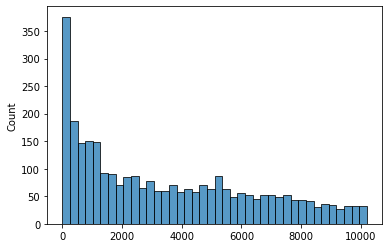

In [16]:
sns.histplot(data=lifetimes_trans, bins=40)

Results from Fit_Weibull_CR (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 2964/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
  Alpha 1         422.135         13.3966   396.678   449.225
   Beta 1        0.969656       0.0245254   0.92276   1.01894
  Alpha 2          619.69         6.77655    606.55   633.115
   Beta 2          6.7306        0.431082   5.93658   7.63083 

Goodness of fit    Value
 Log-likelihood -19480.4
           AICc  38968.8
            BIC  38992.7
             AD  1.88113 



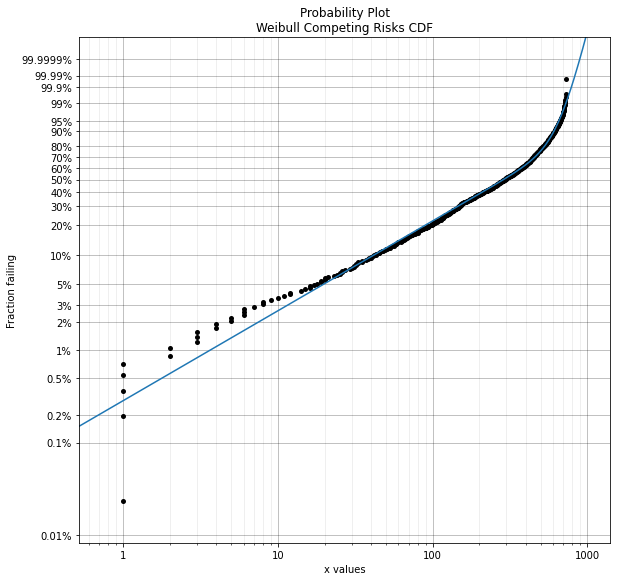

In [17]:
fit = fit_all = Fit_Weibull_CR(failures=lifetimes_all_pos) #, show_probability_plot=False)

#### Regardless of how we transform we have too many modes here

so we might end up with additive or product based mixture model

#### try all relevant distributions

This takes running scipy's optimizer a couple of time to minimize the log likelihood of data (incl right censored data which is absent here).

The code makes us of typical information criteria metrics and employs Anderson-Darling as built-in goodness of fit test.

In [18]:
#fit_all = Fit_Everything(failures=lifetimes_all_pos, show_probability_plot=False)

### Focus on a single class 

In [19]:
# focus on larger disks first
lifetimes_4 = fd[fd['capacity_bytes'] == 4000787030016.0]['lifetime'].values
lifetimes_8 = fd[fd['capacity_bytes'] >= 8001563222016.0]['lifetime'].values
lifetimes_4 = lifetimes_4[lifetimes_4 > 0]
lifetimes_8 = lifetimes_8[lifetimes_8 > 0]


### Exploratory analysis

In [20]:
sp.stats.describe(lifetimes_4)

DescribeResult(nobs=2290, minmax=(1, 730), mean=308.8812227074236, variance=43844.48916233133, skewness=0.22913088799696096, kurtosis=-1.1539144627482705)

<AxesSubplot:ylabel='Count'>

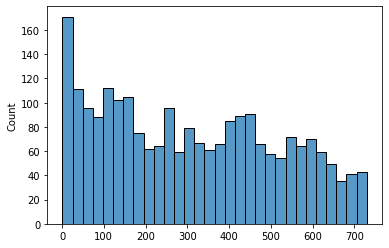

In [21]:
sns.histplot(data=lifetimes_4, bins=30)

#### Again we have an extra mode around 425

Let's see whether we can simply split head and tail following 
https://arxiv.org/ftp/arxiv/papers/1209/1209.2801.pdf

This is a light-tailed distribution so we split the tail instead of the head


In [22]:
head_tail_split = 0.4
def head_tail_break(data, results=None):
    if results is None:
        results = []
    mu = np.mean(data)
    head = data[data > mu]
    tail = data[data < mu]
    results.append(mu)

    while len(head) > 1 and len(head) / len(data) < head_tail_split: return head_tail_break(head, results)
    return results
    

In [23]:
htb = head_tail_break(lifetimes_all)

In [24]:
htb

[308.5587546032809]

<AxesSubplot:ylabel='Count'>

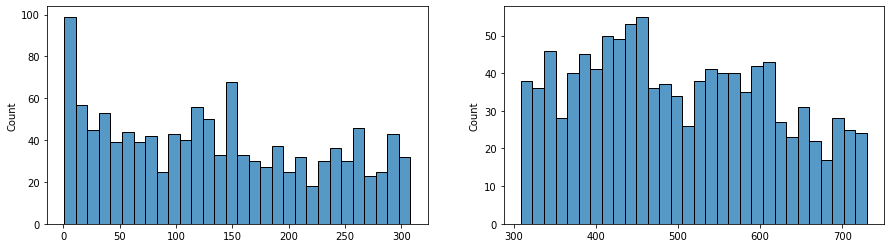

In [25]:
fig,ax = plt.subplots(1,2, figsize=(15,4))
sns.histplot(data=lifetimes_4[lifetimes_4<htb[0]], bins=30, ax=ax[0])
sns.histplot(data=lifetimes_4[lifetimes_4>=htb[0]], bins=30, ax=ax[1])

### Try kneedle 

By intuition the distribution's tail starts with the kneepoint of its (E)CDF.

See also 
https://towardsdatascience.com/detecting-knee-elbow-points-in-a-graph-d13fc517a63c

In [26]:
import kneed
from statsmodels.distributions.empirical_distribution import ECDF

max(lifetimes_4)

730

In [27]:
outecdf_l = ECDF(outage_sev)(np.arange(0,max(lifetimes_4),max(lifetimes_4)/1000))
kneedle = kneed.KneeLocator(range(len(outecdf_l)), outecdf_l,
                            curve="concave", direction="increasing", interp_method="interp1d", S=10)
kneedle.knee, outecdf_l[kneedle.knee]

(184, 0.555)

Text(0.5, 1.0, 'Knee point ECDF at 55%')

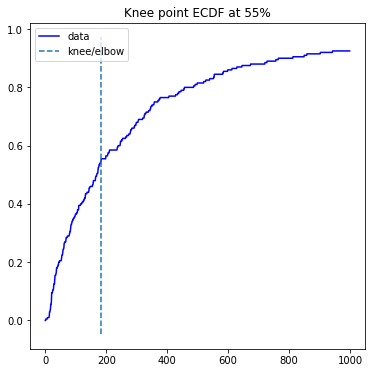

In [28]:
kneedle.plot_knee()
plt.title('Knee point ECDF at ' + str(int(outecdf_l[kneedle.knee]*100)) + '%')

Results from Fit_Everything:
Analysis method: MLE
Failures / Right censored: 1090/0 (0% right censored) 

        Distribution   Alpha    Beta   Gamma Alpha 1  Beta 1 Alpha 2  Beta 2 Proportion 1 DS      Mu    Sigma     Lambda          Xi  Log-likelihood    AICc     BIC      AD   optimizer
     Weibull_Mixture                         419.318 8.92711 606.959 7.35057     0.400675                                                   -6642.63 13295.3 13320.2 1.96827         TNC
          Weibull_3P 235.025 1.88005 291.243                                                                                                -6663.54 13333.1 13348.1  7.3147         TNC
          Weibull_CR                         548.519 4.63286  720.04 87.4682                                                                -6683.97   13376 13395.9 9.26767         TNC
            Gamma_3P 54.6158 4.87252 234.044                                                                                                -6691.58 13389

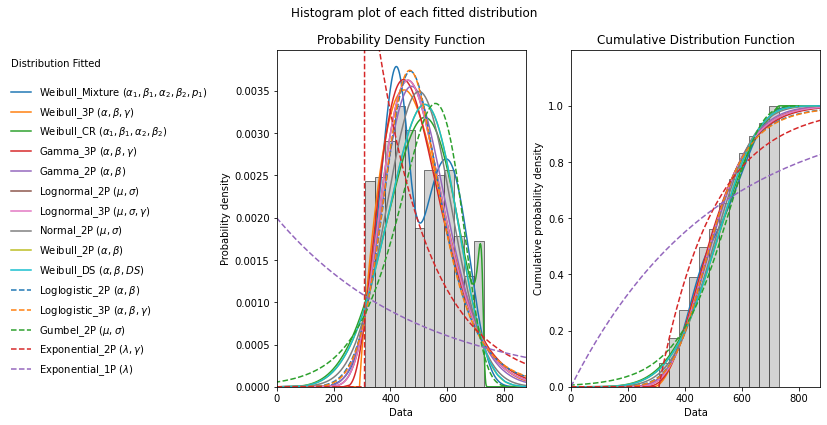

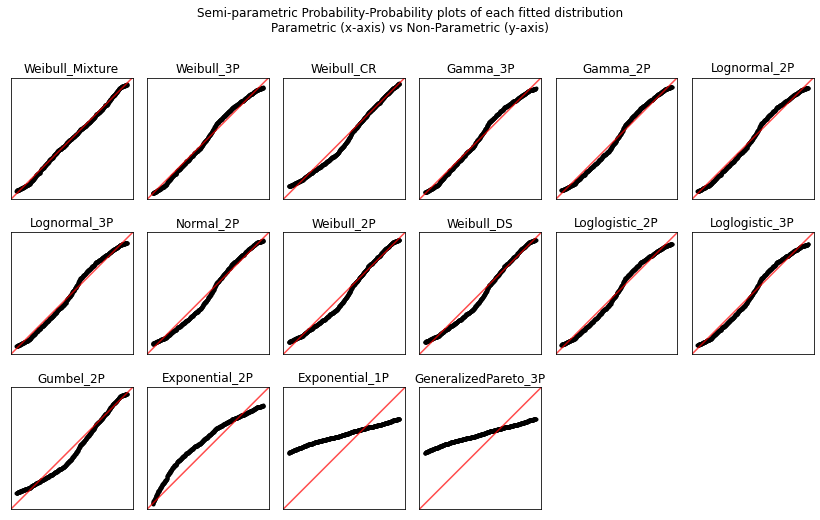

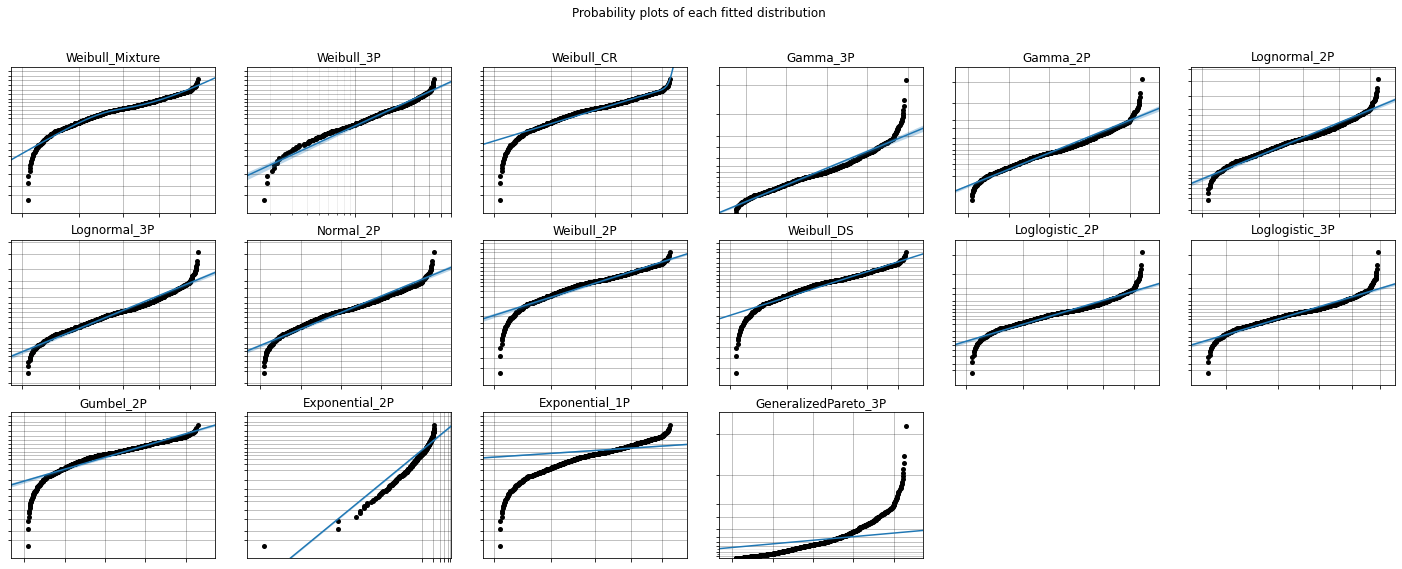

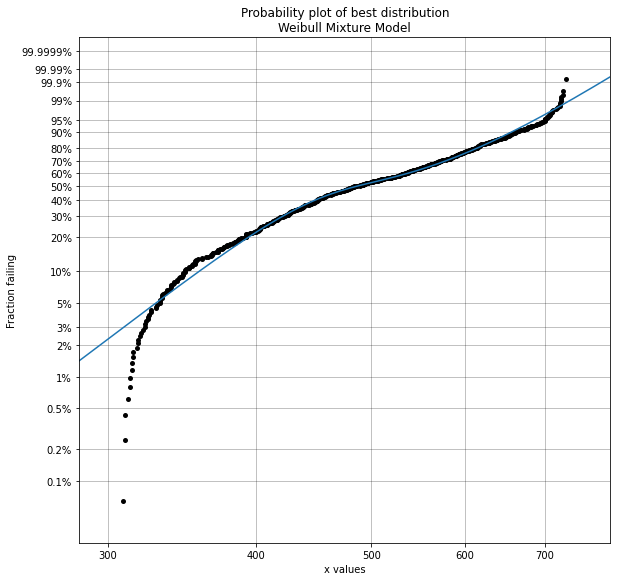

In [29]:
# Fit the tail
lifetimes_44 = lifetimes_4[1200:]
fit444 = Fit_Everything(failures=lifetimes_44)

### Digression: Trying to understand how to fit a Weibull CR model

First, separate data into two group and fit an initial Weibull distribution to each group. These two distributions serve as initial guess for fitting the full CR model.

This is the algorithm proposed in python's reliability package.

730 1
42.67862407862407 0.00024350555781415227


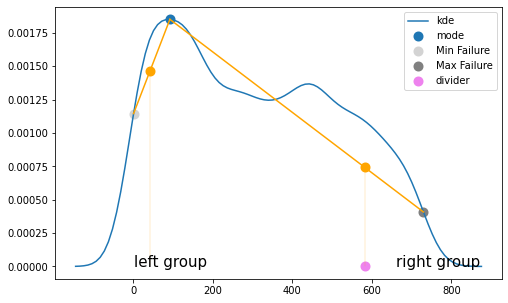

In [46]:
# finding the split point
#   I haven't found a reference for this method

max_failures = max(lifetimes_all_pos)
min_failures = min(lifetimes_all_pos)
print(max_failures, min_failures)

gkde = sp.stats.gaussian_kde(lifetimes_all_pos)
delta = max_failures - min_failures
x_kde = np.linspace(min_failures - delta / 5, max_failures + delta / 5, 100)
y_kde = gkde.evaluate(x_kde)
peak_y = max(y_kde)
peak_x = x_kde[np.where(y_kde == peak_y)][0]


left_x = min_failures
left_y = gkde.evaluate(left_x)
left_m = (peak_y - left_y) / (peak_x - left_x)
left_c = -left_m * left_x + left_y
left_line_x = np.linspace(left_x, peak_x, 1000)
left_line_y = left_m * left_line_x + left_c  # y=mx+c
left_kde = gkde.evaluate(left_line_x)
left_diff = abs(left_line_y - left_kde)
left_diff_max = max(left_diff)
left_div_line = left_line_x[np.where(left_diff == left_diff_max)][0]
print(left_div_line, left_diff_max)

right_x = max_failures
right_y = gkde.evaluate(right_x)
right_m = (right_y - peak_y) / (right_x - peak_x)
right_c = -right_m * right_x + right_y
right_line_x = np.linspace(peak_x, right_x, 1000)
right_line_y = right_m * right_line_x + right_c  # y=mx+c
right_kde = gkde.evaluate(right_line_x)
right_diff = abs(right_line_y - right_kde)
right_diff_max = max(right_diff)
right_div_line = right_line_x[np.where(right_diff == right_diff_max)][0]

if left_diff_max > right_diff_max:
    dividing_line = left_div_line
else:
    dividing_line = right_div_line

#print(dividing_line, left_diff_max, right_diff_max)

max_left_point = left_line_y[np.where(left_diff == left_diff_max)][0]
max_right_point = right_line_y[np.where(right_diff == right_diff_max)][0]

plt.figure(figsize=(8, 5))

plt.plot(x_kde, y_kde, label='kde')
plt.scatter(peak_x, peak_y, lw=4, label='mode')
plt.plot(left_line_x, left_line_y, c='orange')
plt.scatter(left_x, left_y, lw=4, c='lightgrey', label='Min Failure')
plt.scatter(left_div_line, max_left_point, lw=4, c='orange')
plt.plot(right_line_x, right_line_y, c='orange')
plt.scatter(right_x, right_y, lw=4, c='grey', label='Max Failure')
plt.scatter(right_div_line, max_right_point, lw=4, c='orange')
plt.plot((left_div_line,left_div_line), (0, max_left_point), lw=0.4, alpha=0.5, c='orange')
plt.plot((right_div_line,right_div_line), (0, max_right_point), lw=0.4, alpha=0.5, c='orange')
plt.scatter(dividing_line, 0, lw=4, c='violet', label='divider')
plt.annotate('left group', xy=(min_failures, 0), fontsize=15)
plt.annotate('right group', xy=(dividing_line + 80, 0), fontsize=15)
#plt.hist(lifetimes, bins=30, alpha=0.1)


plt.legend()


In [47]:
#lifetimes_all_pos.sort()
group1 = lifetimes_all_pos[lifetimes_all_pos < dividing_line]
group2 = lifetimes_all_pos[lifetimes_all_pos >= dividing_line]
#group1 = lifetimes[lifetimes < 100]
#group2 = lifetimes[lifetimes >= 100]
fit1 = Fit_Weibull_2P(failures=group1, show_probability_plot=False)
fit2 = Fit_Weibull_2P(failures=group2, show_probability_plot=False)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 2562/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         276.435         4.35669   268.027   285.107
     Beta         1.30717       0.0218998   1.26495   1.35081 

Goodness of fit    Value
 Log-likelihood -16671.4
           AICc  33346.9
            BIC  33358.6
             AD  42.9826 

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: L-BFGS-B
Failures / Right censored: 402/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         670.631         2.17275   666.386   674.903
     Beta         16.3098        0.628558   15.1232   17.5895 

Goodness of fit    Value
 Log-likelihood -2102.46
           AICc  4208.95
            BIC  4216.92
             AD  7.45241 



#### Log likelihood of Weibull CR w/o censored data

With Matthew Reid's help I could derive the log likelihood for Weibull CR.

According to "Ishioka, T.; Nonaka, Y. (1991). Maximum likelihood estimation of Weibull parameters for two independent competing risk. , 40(1), 71–74." we have

$$
    SF: R_{CR} = R_1 x R_2  \hspace{.3in} where \hspace{.3in} R_{i} = exp \left( \frac{t}{\alpha_{i}} \right)^{\beta_i}
$$

$$
    CDF: F_{CR} = 1 - R_{CR}
$$

$$
    HF: h_{CR} = h_1 + h_2 \hspace{.3in} where \hspace{.3in} h_i = \frac{\beta_i}{\alpha_i}
    \left(\frac{t}{\alpha_i}\right)^{\beta_i - 1}
$$

$$
    PDF: f_{CR} = h_{CR} x R_{CR} = \left[
       \frac{\beta_1}{\alpha_1} \left(\frac{t}{\alpha_1}\right)^{\beta_1 - 1} +
       \frac{\beta_2}{\alpha_1} \left(\frac{t}{\alpha_2}\right)^{\beta_2 - 1}
    \right] exp \left[ \left( \frac{t}{\alpha_{1}} \right)^{\beta_1} + 
    \left( \frac{t}{\alpha_{2}} \right)^{\beta_2} \right]
$$
.

With f for failure and rc for right-censored data we get


$$
    L(\theta|.) = \prod_{i=n}^{n} f_{CR}(t_i^{f} | \theta) \hspace{.1in} x
      \hspace{.1in} R_{CR}(t_i^{rc} | \theta)
$$


The right-censored data set is empty so taking the log yields

$$
log( L(\theta|.)) = \sum_{i} log \left( \left[ \frac{\beta_2}{t_i} \left( \frac{t_i}{\alpha_2} \right)^{\beta_2} + 
\frac{\beta_1}{t_i} \left( \frac{t_i}{\alpha_1} \right)^{\beta_1} \right]
exp \left[ -\left(\frac{t}{\alpha_2}\right)^{\beta_2} - 
\left(\frac{t}{\alpha_1}\right)^{\beta_1} \right] \right)
  \hspace{.3in},
\theta = (\alpha_1,\alpha_2,\beta_1,\beta_2)
$$ 

#### .

In [48]:
import autograd.numpy as anp
from autograd import value_and_grad
from autograd.differential_operators import hessian
from autograd.scipy.special import gamma as agamma
from autograd.scipy.special import beta as abeta
from autograd.scipy.special import erf

from reliability.Utils import (MLE_optimization)


def logf(t, a1, b1, a2, b2):  # Log PDF for failure data
    return anp.log(
        -(-(b2 * (t / a2) ** b2) / t - (b1 * (t / a1) ** b1) / t)
        * anp.exp(-((t / a2) ** b2) - (t / a1) ** b1)
    )

def logR(t, a1, b1, a2, b2):  # Log SF (Competing Risks)
    return -((t / a1) ** b1) - ((t / a2) ** b2)

def LL(params, T_f, T_rc):
    # Log Likelihood for failure data
    LL_f = logf(
        T_f, params[0], params[1], params[2], params[3]
    ).sum()
    # Log Likelihood survival function for right censored data
    LL_rc = logR(
        T_rc, params[0], params[1], params[2], params[3]
    ).sum()
    return -(LL_f + LL_rc)


In [49]:
MLE_results = MLE_optimization(
            func_name="Weibull_CR",
            LL_func=LL,
            initial_guess= [fit1.alpha, fit1.beta, fit2.alpha, fit2.beta],
            failures=lifetimes_all_pos,
            right_censored=[],
            optimizer="L-BFGS-B"
        )

In [50]:
alpha_1 = MLE_results.alpha_1
beta_1 = MLE_results.beta_1
alpha_2 = MLE_results.alpha_2
beta_2 = MLE_results.beta_2
dist_1 = Weibull_Distribution(alpha=alpha_1, beta=beta_1)
dist_2 = Weibull_Distribution(alpha=alpha_2, beta=beta_2)
full_dist = Competing_Risks_Model(distributions=[dist_1, dist_2])
alpha_1, beta_1, alpha_2, beta_2

(422.13638985852606, 0.9696543464430095, 619.688696131617, 6.7306079241376136)

### On the split point

I wonder whether we could use the modes of both Weibull distributions as split point to fit two independent distributions.

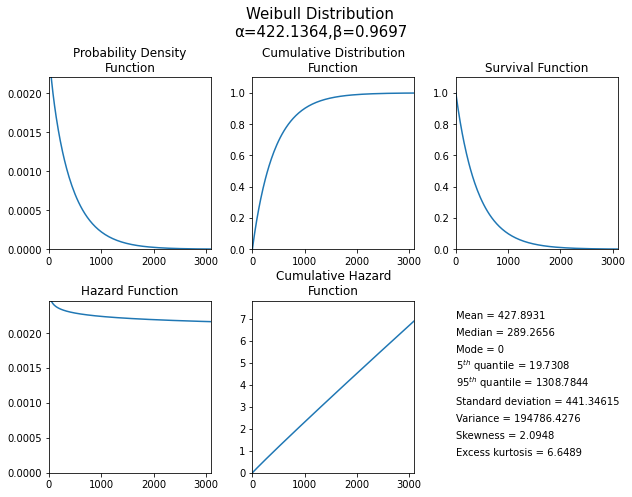

In [51]:
dist_1.plot()

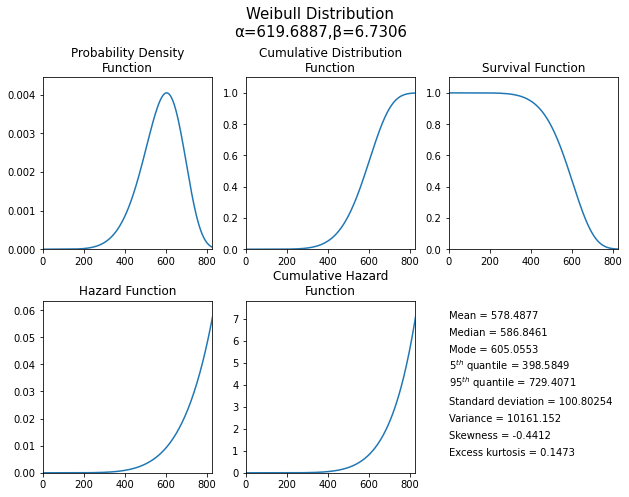

In [52]:
dist_2.plot()

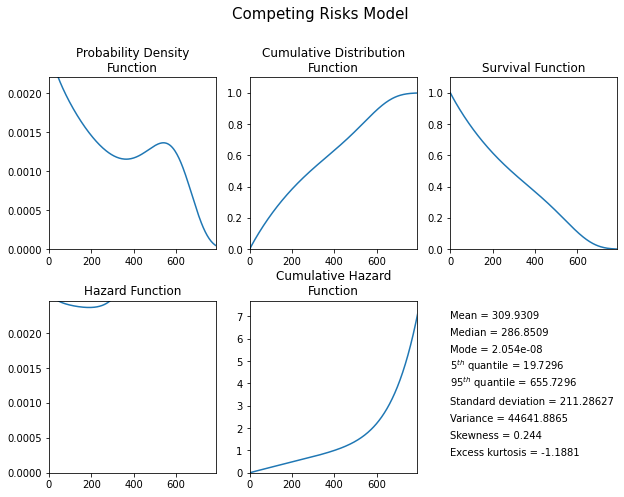

In [53]:
full_dist.plot()

[1.4225565725311327, 0.46134397074389444, 434.8602266134572]

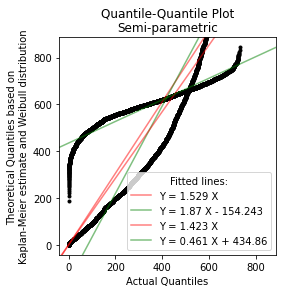

In [54]:
QQ_plot_semiparametric(X_data_failures=lifetimes_all_pos, Y_dist=dist_1) 
QQ_plot_semiparametric(X_data_failures=lifetimes_all_pos, Y_dist=dist_2)

#### Plot the CR

success is not overwhelming but it's performing better than any single distribution fit.

Results from Fit_Weibull_CR (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 2964/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
  Alpha 1         422.135         13.3966   396.678   449.225
   Beta 1        0.969656       0.0245254   0.92276   1.01894
  Alpha 2          619.69         6.77655    606.55   633.115
   Beta 2          6.7306        0.431082   5.93658   7.63083 

Goodness of fit    Value
 Log-likelihood -19480.4
           AICc  38968.8
            BIC  38992.7
             AD  1.88113 



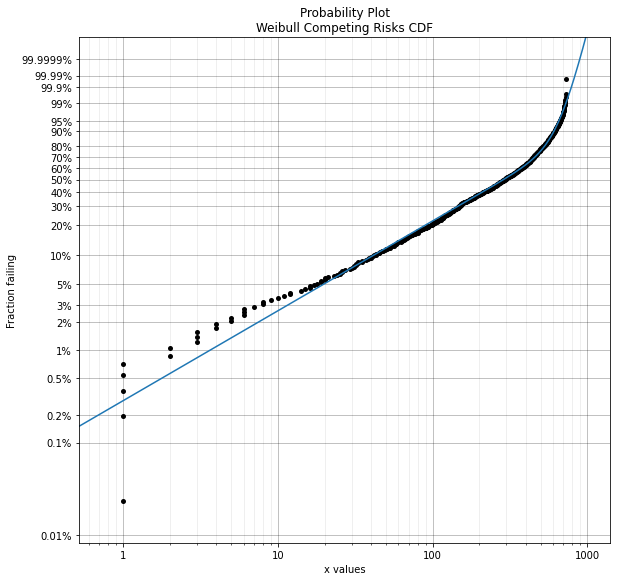

In [55]:
fit = Fit_Weibull_CR(
                    failures=lifetimes_all_pos,
                    right_censored=None,
                    #show_probability_plot=False,
                    #print_results=False,
                    )
plt.show()

### Non parametric models

not yet done

In [56]:
lifetimes_model = fd[fd['model'] == 'ST4000DM000']['lifetime']

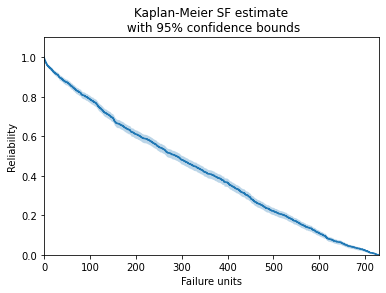

In [57]:
km = KaplanMeier(failures=lifetimes_model, label='Failures only', print_results=False, plot_CI=True)

In [58]:
km_pdf = np.diff(km.CDF)
km.results

,Failure times,Censoring code (censored=0),Items remaining,Kaplan-Meier Estimate,Lower CI bound,Upper CI bound
0,0,1,2004,0.999501,0.998523,1
1,0,1,2003,0.999002,0.99762,1
2,0,1,2002,0.998503,0.99681,1
3,0,1,2001,0.998004,0.99605,0.999958
4,0,1,2000,0.997505,0.995321,0.999689
...,...,...,...,...,...,...
1999,724,1,5,0.00199601,4.19092e-05,0.00395011
2000,725,1,4,0.00149701,0,0.00318973
2001,725,1,3,0.000998004,0,0.00238045
2002,727,1,2,0.000499002,0,0.00147678


### Production pipeline dataset

In [59]:
df_u = pd.read_excel('./data/Production-Pipeline-V9.xlsx')

/home/markus/.local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [60]:
df_u.columns

Index(['MessageID', 'AuthorID', 'Content', 'Date.Created', 'Message.Position', 'ThreadID', 'salutation.p', 'valediction.p', 'Detection.Pass', 'Thread.Duration.Secs', 'Thread.Duration',
       'Thread.Deltas', 'Word.Count.per.Line', 'Total.Lines.per.thread', 'Total.Words.per.thread', 'Total.Users.per.thread', 'entities_relevance1', 'entities_relevance2', 'entities_relevance3',
       'keywords_relevance1', 'keywords_relevance2', 'keywords_relevance3', 'keywords_relevance4', 'keywords_relevance5', 'concepts_relevance', 'emotion_anger_relevance', 'emotion_disgust_relevance',
       'emotion_fear_relevance', 'emotion_joy_relevance', 'emotion_sadness_relevance', 'Sentiment_Score'],
      dtype='object')

In [61]:
df_ut = df_u[['Date.Created','Detection.Pass','Thread.Deltas','Message.Position','ThreadID','Thread.Duration.Secs', 'Total.Words.per.thread', 'Total.Users.per.thread']]
df_ut

,Date.Created,Detection.Pass,Thread.Deltas,Message.Position,ThreadID,Thread.Duration.Secs,Total.Words.per.thread,Total.Users.per.thread
0,2016-05-25 11:11:58,1,0,START,1,17,9,1
1,2016-05-25 11:12:15,1,NaN,END,1,NaN,NaN,NaN
2,2016-05-25 13:32:59,2,140.733,START,2,94151,83,2
3,2016-05-25 13:33:39,NaN,NaN,MIDDLE,2,NaN,NaN,NaN
4,2016-05-25 13:39:22,NaN,NaN,MIDDLE,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3256,2016-12-12 08:50:13,NaN,NaN,MIDDLE,312,NaN,NaN,NaN
3257,2016-12-12 08:50:22,NaN,NaN,MIDDLE,312,NaN,NaN,NaN
3258,2016-12-12 08:50:28,NaN,NaN,MIDDLE,312,NaN,NaN,NaN
3259,2016-12-12 08:50:45,NaN,NaN,MIDDLE,312,NaN,NaN,NaN


#### Fit thread duration

In [62]:
# relevant metrics in START
df_ump = df_ut[df_ut['Message.Position'] == 'START']
df_ump

,Date.Created,Detection.Pass,Thread.Deltas,Message.Position,ThreadID,Thread.Duration.Secs,Total.Words.per.thread,Total.Users.per.thread
0,2016-05-25 11:11:58,1,0,START,1,17,9,1
2,2016-05-25 13:32:59,2,140.733,START,2,94151,83,2
7,2016-06-01 13:10:13,2,8488.05,START,3,6236,99,2
11,2016-06-07 13:48:47,2,8574.63,START,4,508,118,1
15,2016-06-16 07:55:43,2,12598.5,START,5,244,33,1
...,...,...,...,...,...,...,...,...
3228,2016-12-06 14:33:37,4,54.55,START,308,8597,111,2
3235,2016-12-07 12:49:35,4,1192.68,START,309,35024,130,6
3247,2016-12-08 10:00:23,4,687.067,START,310,192,15,1
3249,2016-12-09 09:25:48,4,1402.22,START,311,4610,44,3


In [63]:
thread_d = df_ump['Thread.Duration.Secs'].values.astype(np.float64)

In [64]:
sp.stats.describe(thread_d)

DescribeResult(nobs=257, minmax=(0.9999995231628419, 352101.0000002384), mean=22440.40077820548, variance=1823446687.0658982, skewness=3.8937100499948794, kurtosis=20.077687061679196)

<AxesSubplot:ylabel='Count'>

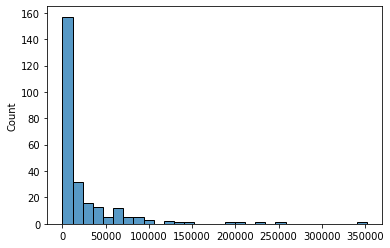

In [65]:
sns.histplot(thread_d, bins=30)

In [66]:
thread_d = df_ump['Thread.Duration.Secs'].values.astype(np.float64)
fit_u = Fit_Weibull_3P(failures=thread_d, show_probability_plot=False)

Results from Fit_Weibull_3P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 257/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         11080.6         1500.78   8497.22   14449.5
     Beta        0.485224        0.023911  0.440551  0.534426
    Gamma          0.9999     0.000139295  0.999627   1.00017 

Goodness of fit   Value
 Log-likelihood -2678.1
           AICc 5362.29
            BIC 5372.84
             AD 1.03575 



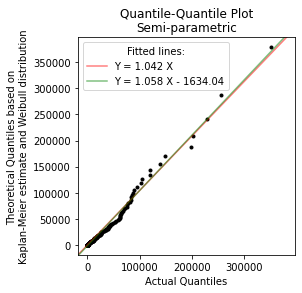

In [67]:
QQ_plot_semiparametric(X_data_failures=thread_d,Y_dist=fit_u.distribution)
plt.show()

#### Fitting users per thread

In [68]:
thread_w = df_ump['Thread.Deltas'].values.astype(np.float64)

In [69]:
sp.stats.describe(thread_w)

DescribeResult(nobs=257, minmax=(-1563.3, 12598.47), mean=644.5850252186772, variance=2214912.031781345, skewness=4.155151732716562, kurtosis=22.518446002193656)

<AxesSubplot:ylabel='Count'>

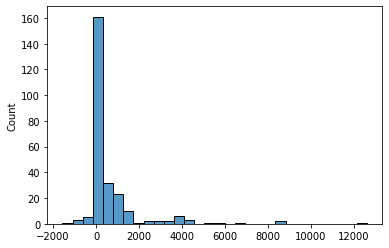

In [70]:
sns.histplot(thread_w, bins=30)

**We should fit a zero inflated model ..**

but we just drop zeros right now

In [71]:
### Cut out 20 elements with 0
thread_ww = thread_w[thread_w > 0]

In [72]:
fit_w = Fit_Weibull_3P(failures=thread_ww, show_probability_plot=False)

Results from Fit_Weibull_3P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 237/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         365.052         49.7888   279.422   476.923
     Beta        0.501319       0.0253556  0.454007  0.553562
    Gamma       0.0332333     0.000141495 0.0329572 0.0335118 

Goodness of fit    Value
 Log-likelihood  -1662.7
           AICc   3331.5
            BIC  3341.81
             AD 0.425331 



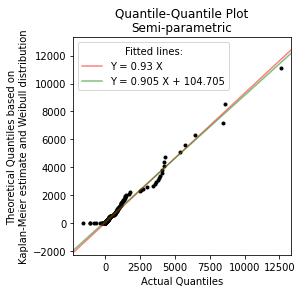

In [73]:
QQ_plot_semiparametric(X_data_failures=thread_w,Y_dist=fit_w.distribution)
plt.show()

### 2015 outage dataset

In [74]:
df_2 = pd.read_csv('./data/2015-alloutages-noSLA.csv')

In [75]:
df_2.columns

Index(['Severity', 'Environment', 'SevMinutes', 'TTRMinutes', 'TTDMinutes', 'SLAMinutes', 'Date', 'component', 'corrective action', 'escape', 'infrastructure', 'type'], dtype='object')

In [76]:
df_2

,Severity,Environment,SevMinutes,TTRMinutes,...,corrective action,escape,infrastructure,type
0,1,G3,121,61,...,correctiveaction_failover,escape_errorinjection,"infrastructure_softlayer, infrastructure_router",type_network
1,1,E3,9,0,...,correctiveaction_deployment,escape_configuration,infrastructure_f5,type_configuration
2,2,E3,145,145,...,correctiveaction_monitoring_newrelic,escape_maintenance,infrastructure_isp,type_network
3,2,E3,133,34,...,correctiveaction_monitoring_newrelic,escape_errorinjection,infrastructure_isp,type_network
4,1,E3,40,26,...,correctiveaction_monitoring_newrelic,escape_loadtesting,infrastructure_websphere,type_memory_leak
5,2,G3,260,135,...,correctiveaction_monitoring_newrelic,escape_loadtesting,infrastructure_websphere,type_memory_leak
6,1,E3,558,18,...,correctiveaction_loadtesting_tooling,escape_loadtesting,infrastructure_websphere,type_contention_underload
7,2,E3,492,353,...,correctiveaction_loadtesting_massonboarding,escape_loadtesting,infrastructure_firewall,type_network_congestion
8,2,E3,19,19,...,correctiveaction_loadtesting_massonboarding,escape_loadtesting,infrastructure_firewall,type_network_congestion
9,2,E3,30,30,...,correctiveaction_loadtesting_massonboarding,escape_loadtesting,infrastructure_firewall,type_network_congestion


In [77]:
outage_sev = df_2['SevMinutes'].values

In [78]:
sp.stats.describe(outage_sev)

DescribeResult(nobs=200, minmax=(1, 21480), mean=357.95, variance=2443828.5201005028, skewness=12.519710079499443, kurtosis=165.51157742583965)

<AxesSubplot:ylabel='Count'>

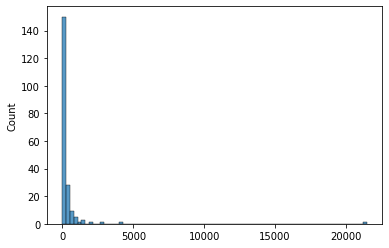

In [79]:
sns.histplot(outage_sev, bins=80)

Results from Fit_Lognormal_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 200/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
       Mu         4.73208       0.0972733   4.54143   4.92273
    Sigma         1.37565       0.0687826   1.24724   1.51729 

Goodness of fit    Value
 Log-likelihood -1293.99
           AICc  2592.04
            BIC  2598.58
             AD 0.466903 



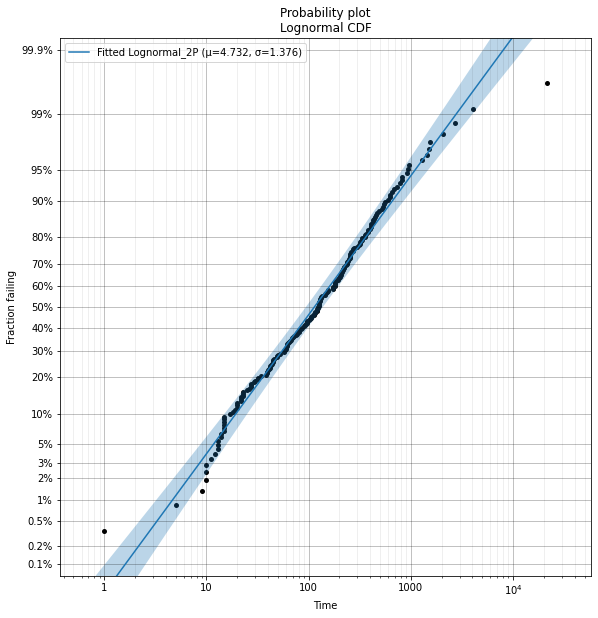

In [80]:
fit_2 = Fit_Lognormal_2P(failures=outage_sev, show_probability_plot=True)

In [81]:
#QQ_plot_semiparametric(X_data_failures=outage_sev,Y_dist=fit_2.distribution)
#plt.show()

#### TTR Minutes

In [82]:
ttr = df_2['TTRMinutes'].values

In [83]:
sp.stats.describe(ttr)

DescribeResult(nobs=200, minmax=(0, 1527), mean=100.855, variance=22588.30550251256, skewness=5.290202018213859, kurtosis=42.109488138225316)

<AxesSubplot:ylabel='Count'>

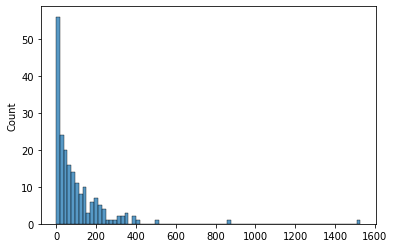

In [84]:
sns.histplot(ttr, bins=80)

In [85]:
ttr_1 = ttr + 1  # no null

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 200/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         88.4055         8.36633   73.4387   106.422
     Beta        0.787063       0.0427055  0.707658  0.875376 

Goodness of fit    Value
 Log-likelihood -1113.51
           AICc  2231.08
            BIC  2237.62
             AD 0.526022 



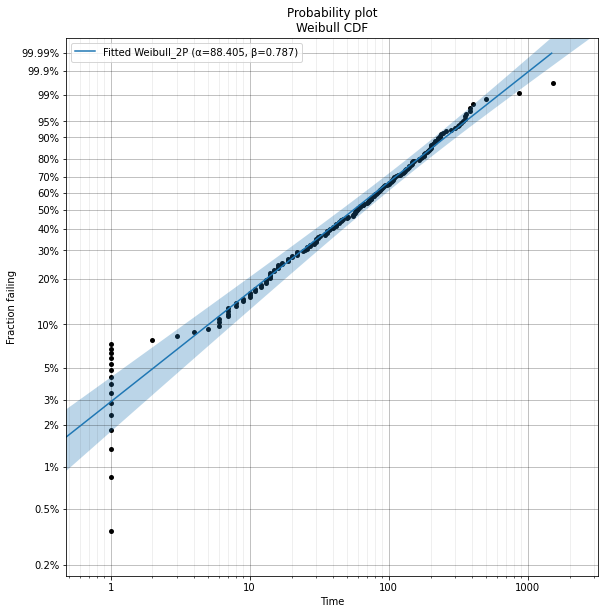

In [86]:
fit_2t = Fit_Weibull_2P(failures=ttr_1, show_probability_plot=True)

In [87]:
#QQ_plot_semiparametric(X_data_failures=ttr_1,Y_dist=fit_2t.distribution)
#plt.show()

In [88]:
fit_2t.distribution.alpha, fit_2t.distribution.beta, fit_2t.distribution.gamma

(88.40549313552718, 0.7870625077541353, 0.0)

In [89]:
fit_2t.distribution.gamma = 0

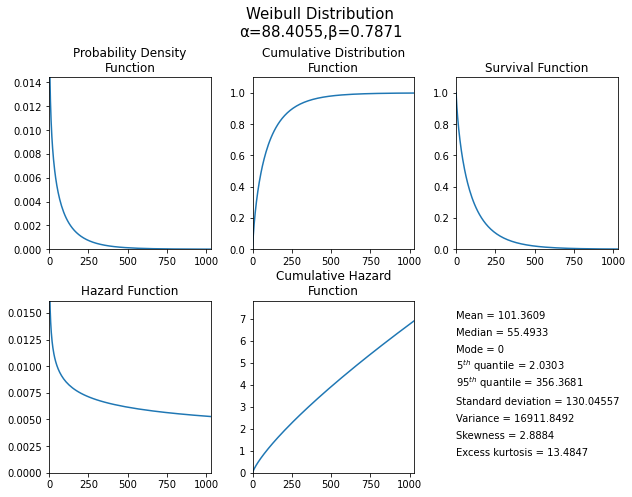

In [90]:
fit_2t.distribution.plot()